In [31]:
import pandas as pd
import numpy as np
import re
import json
import os
from datetime import date
import pandas_profiling
import datetime as dt
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import auc, roc_auc_score, roc_curve, multilabel_confusion_matrix
from sklearn.preprocessing import Normalizer, normalize
from collections import Counter
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict

import warnings

In [32]:
train = pd.read_csv('2021-08-29_train.csv')
test = pd.read_csv('test.csv')

In [33]:
def clean_smb(smb):
    ''' the function does remove the symbols
    in the string data'''

    smb = smb.replace("}",'')
    smb = smb.replace("{",'')
    smb = smb.replace("]",'')
    smb = smb.replace("]",'')
    smb = smb.replace('"','')
    smb = smb.strip('[]')
    smb = smb.split(',')
    return smb

In [34]:
def bin_plot(col):
    """Does plot the binary features visualisation"""
    labels = list(data.query('default == 1')[col].value_counts().index)

    total = data[col].value_counts()
    defaulters = data.query('default==1')[col].value_counts()

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, total, width,  label='Total')
    rects2 = ax.bar(x + width/2, defaulters, width, color = 'r', label='Defaulters')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Amount')
    ax.set_title('Defaulters 0/1 in feature {}'.format(col))
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()

    plt.show()
    print('Share of default in total','\n', defaulters/total)

In [35]:
def check_df_before_merg(d_df1,d_df2):
    ''' the function to compare of data types both datasets
    was copied from SF colleagues'''

    list_of_names1 = list(d_df1.columns)
    temp_dict = {}
    temp_dict['feature_train'] = list_of_names1
    temp_dict['type_train'] = d_df1.dtypes
    temp_dict['sample_train'] = d_df1.loc[5].values
    temp_df1 = pd.DataFrame.from_dict(temp_dict)


    list_of_names2 = list(d_df2.columns)
    temp_dict2 = {}
    temp_dict2['feature_test'] = list_of_names2
    temp_dict2['type_test'] = d_df2.dtypes
    temp_dict2['sample_test'] = d_df2.loc[5].values
    temp_df2 = pd.DataFrame.from_dict(temp_dict2)

    temp_insert = pd.DataFrame(columns=['< - >'])

    temp_df = pd.concat([temp_df1,temp_insert, temp_df2], axis=1, sort=False)
    temp_df.reset_index(inplace = True)
    del temp_df['index']
    temp_df['< - >'] = '| - |'
    display(temp_df)

    temp_dict3 = {}
    temp_df3= pd.DataFrame(temp_df)
    temp_list  = []
    temp_list2  = []
    temp_list3  = []
    temp_list4  = []


    for i in range(len(temp_df)):
        if str(temp_df3['type_train'][i]) != str(temp_df3['type_test'][i]):
            temp_list.append(temp_df3['feature_train'][i])
            temp_list2.append(temp_df3['feature_test'][i])
            temp_list3.append(str(temp_df3['type_train'][i]) + ' != ' + str(temp_df3['type_test'][i]))
            temp_list4.append(i)

    temp_dict3['index']= temp_list4
    temp_dict3['feature_train']= temp_list
    temp_dict3['divergences'] = temp_list3
    temp_dict3['feature_test']= temp_list2

    temp_df4 = pd.DataFrame.from_dict(temp_dict3)
    temp_df4.set_index('index',inplace=True)

    print(f'The data types are different in {len(temp_df4)} columns\n')
    display(temp_df4)

In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59762 entries, 0 to 59761
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            59762 non-null  int64  
 1   bodyType              59761 non-null  object 
 2   brand                 59762 non-null  object 
 3   color                 59762 non-null  object 
 4   complectation_dict    59762 non-null  object 
 5   description           57794 non-null  object 
 6   engineDisplacement    59762 non-null  float64
 7   enginePower           59762 non-null  int64  
 8   equipment_dict        59762 non-null  object 
 9   fuelType              59761 non-null  object 
 10  image                 59762 non-null  object 
 11  mileage               59762 non-null  int64  
 12  modelDate             59762 non-null  int64  
 13  model_info            59762 non-null  object 
 14  model_name            59762 non-null  object 
 15  name               

In [37]:
train.drop(['Unnamed: 0'], axis=1, inplace=True)

In [38]:
train.head(3)

bodyType       brand       color complectation_dict  \
0  внедорожник 5 дв.  ALFA_ROMEO  коричневый        {'id': '0'}   
1              седан  ALFA_ROMEO      чёрный        {'id': '0'}   
2      хэтчбек 5 дв.  ALFA_ROMEO     красный        {'id': '0'}   

                                         description  engineDisplacement  \
0  Мы предлагаем Вам сформированные индивидуальны...                 2.0   
1  Мы предлагаем Вам сформированные индивидуальны...                 2.0   
2  Мы предлагаем Вам сформированные индивидуальны...                 1.4   

   enginePower                                     equipment_dict fuelType  \
0          200  {'asr': True, 'airbag-driver': True, 'aux': Tr...   бензин   
1          280  {'asr': True, 'airbag-driver': True, 'usb': Tr...   бензин   
2          170  {'cruise-control': True, 'asr': True, 'tinted-...   бензин   

                                               image  ...  \
0  //avatars.mds.yandex.net/get-autoru-vos/447689...  ...   
1  //avatars.mds.yandex.net/get-autoru-vos/530062...  ...   
2  //avatars.mds.yandex.net/get-autoru-vos/412107...  ...   

                                vehicleConfiguration  vehicleTransmission  \
0     2.0 AT (200 л.с.), внедорожник, полный, бензин       автоматическая   
1           2.0 AT (280 л.с.), седан, полный, бензин       автоматическая   
2  1.4 AMT (170 л.с.), хэтчбек 5 дв., передний, б...             вариатор   

     vendor Владельцы Владение       ПТС    Привод   Руль           Состояние  \
0  EUROPEAN         2     12.0  Оригинал    полный  Левый  Не требует ремонта   
1  EUROPEAN         1     12.0  Оригинал    полный  Левый  Не требует ремонта   
2  EUROPEAN         1     12.0  Оригинал  передний  Левый  Не требует ремонта   

      Таможня  
0  Растаможен  
1  Растаможен  
2  Растаможен  

[3 rows x 31 columns]

In [39]:
train.shape

(59762, 31)

In [40]:
test.head(3)

bodyType  brand                                            car_url   color  \
0  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   синий   
1  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...  чёрный   
2  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/superb/11...   серый   

                                  complectation_dict  \
0                                                NaN   
1                                                NaN   
2  {"id":"20026336","name":"Ambition","available_...   

                                         description engineDisplacement  \
0  Все автомобили, представленные в продаже, прох...            1.2 LTR   
1  ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...            1.6 LTR   
2  Все автомобили, представленные в продаже, прох...            1.8 LTR   

  enginePower                                     equipment_dict fuelType  \
0     105 N12  {"engine-proof":true,"tinted-glass":true,"airb...   бензин   
1     110 N12  {"cruise-control":true,"asr":true,"esp":true,"...   бензин   
2     152 N12  {"cruise-control":true,"tinted-glass":true,"es...   бензин   

   ...     vehicleConfiguration  vehicleTransmission    vendor    Владельцы  \
0  ...       LIFTBACK ROBOT 1.2     роботизированная  EUROPEAN  3 или более   
1  ...  LIFTBACK MECHANICAL 1.6         механическая  EUROPEAN   1 владелец   
2  ...       LIFTBACK ROBOT 1.8     роботизированная  EUROPEAN   1 владелец   

  Владение       ПТС    Привод   Руль           Состояние     Таможня  
0      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  
1      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  
2      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  

[3 rows x 32 columns]

In [41]:
test.shape

(34686, 32)

for further convenience let's input the features for
* for testing dataset as 'sample' = 0
* for training dataset as 'sample' = 1

In [42]:
train['sample'] = 1
test['sample'] = 0
print(f'The training dataset with {train.shape} and testing dataset with {test.shape} can be combined')

The training dataset with (59762, 32) and testing dataset with (34686, 33) can be combined


In [43]:
check_df_before_merg(train, test)

feature_train type_train  \
0               bodyType     object   
1                  brand     object   
2                  color     object   
3     complectation_dict     object   
4            description     object   
5     engineDisplacement    float64   
6            enginePower      int64   
7         equipment_dict     object   
8               fuelType     object   
9                  image     object   
10               mileage      int64   
11             modelDate      int64   
12            model_info     object   
13            model_name     object   
14                  name     object   
15         numberOfDoors      int64   
16      parsing_unixtime      int64   
17                 price      int64   
18         priceCurrency     object   
19        productionDate      int64   
20             super_gen     object   
21  vehicleConfiguration     object   
22   vehicleTransmission     object   
23                vendor     object   
24             Владельцы      int64   
25              Владение    float64   
26                   ПТС     object   
27                Привод     object   
28                  Руль     object   
29             Состояние     object   
30               Таможня     object   
31                sample      int64   
32                   NaN        NaN   
33                   NaN        NaN   

                                         sample_train  < - >  \
0                                       хэтчбек 5 дв.  | - |   
1                                          ALFA_ROMEO  | - |   
2                                               белый  | - |   
3                                         {'id': '0'}  | - |   
4   РОЛЬФ Алтуфьево — это целых 30 лет успешной по...  | - |   
5                                                 1.4  | - |   
6                                                 170  | - |   
7   {'cruise-control': True, 'asr': True, 'esp': T...  | - |   
8                                              бензин  | - |   
9   //avatars.mds.yandex.net/get-autoru-vos/392674...  | - |   
10                                              42500  | - |   
11                                               2010  | - |   
12  {'code': 'GIULIETTA', 'name': 'Giulietta', 'ru...  | - |   
13                                          Giulietta  | - |   
14                                 1.4 AMT (170 л.с.)  | - |   
15                                                  5  | - |   
16                                         1629806291  | - |   
17                                            1300000  | - |   
18                                                RUR  | - |   
19                                               2014  | - |   
20  {'id': '8484175', 'name': 'III', 'ru_name': '3...  | - |   
21  1.4 AMT (170 л.с.), хэтчбек 5 дв., передний, б...  | - |   
22                                           вариатор  | - |   
23                                           EUROPEAN  | - |   
24                                                  1  | - |   
25                                               12.0  | - |   
26                                           Оригинал  | - |   
27                                           передний  | - |   
28                                              Левый  | - |   
29                                 Не требует ремонта  | - |   
30                                         Растаможен  | - |   
31                                                  1  | - |   
32                                                NaN  | - |   
33                                                NaN  | - |   

            feature_test type_test  \
0               bodyType    object   
1                  brand    object   
2                  color    object   
3     complectation_dict    object   
4            description    object   
5     engineDisplacement    object   
6            enginePower    object   
7         equipment_dict    object   
8               fuelType    object   
9                  image

The data types are different in 7 columns



feature_train        divergences        feature_test
index                                                           
5      engineDisplacement  float64 != object  engineDisplacement
6             enginePower    int64 != object         enginePower
17                  price       int64 != nan                 NaN
24              Владельцы    int64 != object           Владельцы
25               Владение  float64 != object            Владение
32                    NaN      nan != object             car_url
33                    NaN       nan != int64             sell_id

### price is the target feature

In [44]:
y_train = train['price'].astype(int)
train.drop(['price'], axis = 1, inplace=True)

In [45]:
train.shape

(59762, 31)

In [46]:
test.shape

(34686, 33)

In [47]:
#Combine the datasets
data = test.append(train, sort=False).reset_index(drop=True)

data.shape

(94448, 33)

In [48]:
data.sample(5)

bodyType     brand  \
66206            минивэн  MERCEDES   
93427  внедорожник 5 дв.     VOLVO   
70531              седан    NISSAN   
11847  внедорожник 5 дв.    NISSAN   
39646            лифтбек       BMW   

                                                 car_url        color  \
66206                                                NaN       чёрный   
93427                                                NaN   коричневый   
70531                                                NaN  серебристый   
11847  https://auto.ru/cars/used/sale/nissan/qashqai/...    пурпурный   
39646                                                NaN      голубой   

                                      complectation_dict  \
66206                                        {'id': '0'}   
93427                                        {'id': '0'}   
70531                                        {'id': '0'}   
11847  {"id":"21156560","name":"SE+","available_optio...   
39646                                        {'id': '0'}   

                                             description engineDisplacement  \
66206  Покупал для себя в начале был лизинг, теперь м...                2.1   
93427  💸Выгода до 100 000 рублей при покупке в кредит...                2.4   
70531  Добрый день\nИз плюсов:\nСухой мотор\nНовые ры...                2.0   
11847              Без ДТП. Состояние нового автомобиля.            2.0 LTR   
39646  Понторезка, дерзкая и роскошная! В идеальном с...                2.0   

      enginePower                                     equipment_dict fuelType  \
66206         190  {'tinted-glass': True, 'esp': True, 'ptf': Tru...   дизель   
93427         181  {'asr': True, 'tinted-glass': True, 'esp': Tru...   дизель   
70531         140                           {'audiosystem-cd': True}   бензин   
11847     144 N12  {"cruise-control":true,"esp":true,"airbag-driv...   бензин   
39646         245  {'alcantara': True, 'multizone-climate-control...   бензин   

       ... vehicleTransmission    vendor   Владельцы Владение       ПТС  \
66206  ...      автоматическая  EUROPEAN           2     12.0  Оригинал   
93427  ...      автоматическая  EUROPEAN           1     12.0  Оригинал   
70531  ...        механическая  JAPANESE           3     12.0  Оригинал   
11847  ...            вариатор  JAPANESE  1 владелец      NaN  Оригинал   
39646  ...      автоматическая  EUROPEAN           2     12.0  Оригинал   

         Привод   Руль           Состояние     Таможня  sample  
66206    полный  Левый  Не требует ремонта  Растаможен       1  
93427    полный  Левый  Не требует ремонта  Растаможен       1  
70531  передний  Левый  Не требует ремонта  Растаможен       1  
11847  передний  Левый  Не требует ремонта  Растаможен       0  
39646    полный  Левый  Не требует ремонта  Растаможен       1  

[5 rows x 33 columns]

# 2. Data cleaning and Exploratory Data Analysis (EDA)
## 2.1 Features analysis

### Pandas profiling analyse

In [49]:
pandas_profiling.ProfileReport(data)

Summarize dataset:   0%|          | 0/46 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

* _'Состояние','Таможня','priceCurrency',  are constant values and there is no sense for any further treatment._ _They are being droped._
* _'car url' can give no information directly and doesn't matter for the prediction model._
* _'image' can give no information directla and doesn'matter for the prediction model._
* _'super gen' contains alot of technical information, however the test data set doesn't contain the data in the feature._
* _'sell id' doesn't contain any useful information._
* _'vehicleConfiguration' duplicates the information are provided by other features._
* _'description' doesn't contains useful information._
* _'model info duplicates the information are provided by other features._


In [50]:
data.columns

Index(['bodyType', 'brand', 'car_url', 'color', 'complectation_dict',
       'description', 'engineDisplacement', 'enginePower', 'equipment_dict',
       'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name',
       'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency',
       'productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration',
       'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС',
       'Привод', 'Руль', 'Состояние', 'Таможня', 'sample'],
      dtype='object')

In [51]:
data.drop(['Состояние', 'Таможня', 'priceCurrency', 'car_url', 'image', 'super_gen',
                  'sell_id', 'vehicleConfiguration', 'description', 'model_info', 'parsing_unixtime'], axis = 1, inplace=True)

In [52]:
df = data
df.columns

Index(['bodyType', 'brand', 'color', 'complectation_dict',
       'engineDisplacement', 'enginePower', 'equipment_dict', 'fuelType',
       'mileage', 'modelDate', 'model_name', 'name', 'numberOfDoors',
       'productionDate', 'vehicleTransmission', 'vendor', 'Владельцы',
       'Владение', 'ПТС', 'Привод', 'Руль', 'sample'],
      dtype='object')

## 2.2 Data preprocessing

## 2.2.1 bodyType

### aggregation of feature bodyType by  main types

In [85]:
def feature_overview(feature):
    print(f'Total lines: {len(feature)}')
    print(f'Data types: {feature.dtypes}')
    print(f'Total values: {feature.count()}')
    print(f'The most frequent value: {feature.value_counts(sort=True).keys()[0]}')
    print(f'Unique values: {feature.nunique()}')
    print(f'Missing values: {feature.isna().sum()}')
    sns.countplot(y = feature, order = feature.value_counts(sort=True).index)

    return

Total lines: 94448
Data types: object
Total values: 94447
The most frequent value: седан
Unique values: 25
Missing values: 1


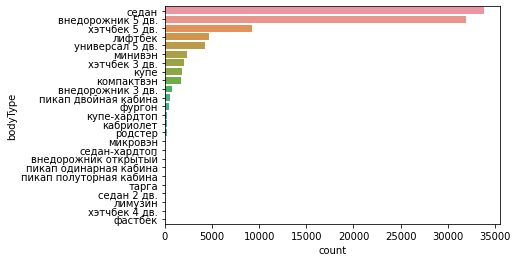

In [86]:
feature_overview(df.bodyType)

dtype('O')

In [ ]:
df.bodyType.value_counts(sort=True)

In [279]:
df.bodyType.isna().sum()

1

In [280]:
df['bodyType'] = df.bodyType.fillna(df.bodyType.value_counts(sort=True).keys()[0])



bodyType_list = []
for i in range(len(df.bodyType)):
    bodyType_list.append(df.bodyType[i].replace('-', ' ').split(' ')[0])#unique bodyTypes
df['bodyType'] = bodyType_list

groupping by main types

In [281]:
df.bodyType.replace('фастбек', 'универсал' ,inplace=True)
df.bodyType.replace('купе', 'универсал' ,inplace=True)
df.bodyType.replace('микровэн', 'минивэн' ,inplace=True)
df.bodyType.replace( 'хэтчбек', 'универсал',inplace=True)
df.bodyType.replace( 'лифтбек', 'универсал',inplace=True)
df.bodyType.replace('компактвэн', 'минивэн' ,inplace=True)
df.bodyType.replace('тарга', 'родстер' ,inplace=True)
df.bodyType.replace('фургон', 'пикап' ,inplace=True)

In [282]:
df.bodyType.value_counts(sort=True)


седан          33866
внедорожник    32714
универсал      22246
минивэн         4100
пикап           1032
кабриолет        252
родстер          230
лимузин            8
Name: bodyType, dtype: int64

<AxesSubplot:xlabel='count', ylabel='bodyType'>

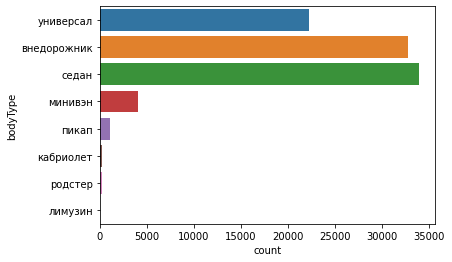

In [283]:
sns.countplot(y = df.bodyType)

In [284]:
print(f'There are {df.bodyType.nunique()} main body-types of the presented cars left for further data processing')


There are 8 main body-types of the presented cars left for further data processing


## 2.2.2 brand

In [285]:
df.brand.isna().sum()

0

In [286]:
df.brand.value_counts()

BMW           8148
VOLKSWAGEN    8080
MERCEDES      7852
NISSAN        7685
TOYOTA        7478
AUDI          6050
MITSUBISHI    5134
SKODA         5066
VAZ           3686
KIA           3677
HYUNDAI       3676
FORD          3340
VOLVO         2653
CHEVROLET     2247
RENAULT       2142
HONDA         2110
OPEL          1887
LEXUS         1874
MAZDA         1679
INFINITI      1469
LAND_ROVER    1211
PEUGEOT       1014
PORSCHE        739
DAEWOO         724
CITROEN        667
SUZUKI         550
SUBARU         511
JEEP           387
GAZ            345
CHERY          332
GREAT_WALL     259
MINI           239
JAGUAR         233
LIFAN          211
CHRYSLER       200
FIAT           165
DATSUN         152
GEELY          145
SMART          110
SAAB            89
SEAT            62
TESLA           51
ROVER           49
ALFA_ROMEO      48
ISUZU           22
Name: brand, dtype: int64

In [287]:
df = df[df['brand'].map(df['brand'].value_counts(sort=True)>1000)] #filtration based on value_counts
df.shape

(88158, 22)

## 2.2.3 color

In [288]:
df.color.isna().sum()

0

In [289]:
df.color.value_counts()


чёрный         25133
белый          16711
серебристый    11336
серый           9763
синий           8561
красный         4271
коричневый      3764
зелёный         2577
бежевый         1764
голубой         1166
золотистый       805
пурпурный        719
фиолетовый       636
жёлтый           531
оранжевый        394
розовый           27
Name: color, dtype: int64

## 2.2.4  complectation_dict  &  equipment_dict
 _with nested options dictionary_

_the features look same and they have to be mearged_

In [290]:
print(f'the complectation_dict has {df.complectation_dict.isna().sum()} of missing values')

print(f'the equipment_dict has {df.equipment_dict.isna().sum()} of missing values')

the complectation_dict has 28268 of missing values
the equipment_dict has 9996 of missing values


they are filled with ''No Value' value

In [291]:
df['complectation_dict'] = df['complectation_dict'].fillna('No value').astype(str)
df['equipment_dict'] = df['equipment_dict'].fillna('No value').astype(str)

<ipython-input-291-b927a38c2e48>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['complectation_dict'] = df['complectation_dict'].fillna('No value').astype(str)
<ipython-input-291-b927a38c2e48>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['equipment_dict'] = df['equipment_dict'].fillna('No value').astype(str)


let's try to extract the optioins

In [292]:
#there is also no useful information. To replace on 'No value' also.
pat = "'id': '0'"
df['complectation_dict'] = df['complectation_dict'].map(lambda x: x if pat  not in x else 'No value')

<ipython-input-292-36ae2e21bac3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['complectation_dict'] = df['complectation_dict'].map(lambda x: x if pat  not in x else 'No value')


In [163]:
#useful data extracting string partition method.
cmpl_opt = []
for row in df.complectation_dict:
    try:
        line = row.partition('"available_options":')[-1]
        line = line.partition('"vendor_color')[0]
        cmpl_opt.append(line)
    except:
        cmpl_opt.append('No value')

df['complectation_dict'] = cmpl_opt

<ipython-input-163-878a95fb43b2>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['complectation_dict'] = cmpl_opt


In [164]:
df['complectation_dict'] = df['complectation_dict'].apply(clean_smb)
df['complectation_dict']

<ipython-input-164-02da60fcbc48>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['complectation_dict'] = df['complectation_dict'].apply(clean_smb)


0                                                       []
1                                                       []
2        [heated-wash-system, airbag-passenger, lock, d...
3        [heated-wash-system, airbag-passenger, lock, e...
4                                                       []
                               ...                        
94443                                                   []
94444                                                   []
94445                                                   []
94446                                                   []
94447                                                   []
Name: complectation_dict, Length: 88158, dtype: object

In [165]:
# extract the options form equipment_dict
df['equipment_dict'] = df['equipment_dict'].apply(clean_smb)

row_lst = []
for row in df.equipment_dict:
    eq_lst = []
    for item in row:
        if item == item:
            key = item.split(':')[0]
            eq_lst.append(key)
        else:
            eq_lst.append('No value')

    row_lst.append(eq_lst)

df['equipment_dict'] = row_lst

<ipython-input-165-c4fa2881d567>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['equipment_dict'] = df['equipment_dict'].apply(clean_smb)
<ipython-input-165-c4fa2881d567>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['equipment_dict'] = row_lst


In [166]:
#Uniting the values in columns equipment_dict and equipment_dict
options = []
for i, j in zip(df.complectation_dict, df.equipment_dict):
    options.append(i+j)
df['options'] = options

<ipython-input-166-524753cfc5af>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['options'] = options


In [167]:
df['options']

0        [, engine-proof, tinted-glass, airbag-driver, ...
1        [, cruise-control, asr, esp, airbag-driver, is...
2        [heated-wash-system, airbag-passenger, lock, d...
3        [heated-wash-system, airbag-passenger, lock, e...
4        [, cruise-control, asr, esp, airbag-driver, is...
                               ...                        
94443    [, 'cruise-control',  'asr',  'tinted-glass', ...
94444    [, 'engine-proof',  'esp',  'airbag-driver',  ...
94445                                                 [, ]
94446                                                 [, ]
94447    [, 'electro-window-back',  'alloy-wheel-disks'...
Name: options, Length: 88158, dtype: object

In [168]:
df.shape

(88158, 24)

In [169]:
#To make a list of most used options
df1 = df
df1 = df.explode('options')

In [170]:
#List of most used options
options_lst = df1.options.value_counts(sort=True).keys().map(lambda x: x.replace("\'",'').replace(" ", ""))[1:80]
options_lst = set(options_lst)
options_lst

{'abs',
 'airbag-driver',
 'airbag-passenger',
 'airbag-side',
 'aux',
 'computer',
 'electro-mirrors',
 'electro-window-back',
 'electro-window-front',
 'esp',
 'front-seats-heat',
 'immo',
 'lock',
 'mirrors-heat',
 'multi-wheel',
 'ptf',
 'usb',
 'wheel-leather',
 'wheel-power'}

In [171]:
df.shape

(88158, 24)

In [172]:
row_lst = []
for row in df.options:
    opt_lst = []
    for item in row:
        for opt in options_lst:
            if item == opt:
                opt_lst.append(item)
            else:
                continue
    row_lst.append(opt_lst)

In [173]:
df['options'] = row_lst

<ipython-input-173-7829413d05f1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['options'] = row_lst


In [174]:
df

bodyType  brand       color  \
0      универсал  SKODA       синий   
1      универсал  SKODA      чёрный   
2      универсал  SKODA       серый   
3      универсал  SKODA  коричневый   
4      универсал  SKODA       белый   
...          ...    ...         ...   
94443      седан  VOLVO       серый   
94444      седан  VOLVO     зелёный   
94445      седан  VOLVO      чёрный   
94446      седан  VOLVO      чёрный   
94447      седан  VOLVO      чёрный   

                                      complectation_dict engineDisplacement  \
0                                                     []            1.2 LTR   
1                                                     []            1.6 LTR   
2      [heated-wash-system, airbag-passenger, lock, d...            1.8 LTR   
3      [heated-wash-system, airbag-passenger, lock, e...            1.6 LTR   
4                                                     []            1.8 LTR   
...                                                  ...                ...   
94443                                                 []                2.5   
94444                                                 []                2.4   
94445                                                 []                2.4   
94446                                                 []                2.4   
94447                                                 []                2.4   

      enginePower                                     equipment_dict fuelType  \
0         105 N12  [engine-proof, tinted-glass, airbag-driver, au...   бензин   
1         110 N12  [cruise-control, asr, esp, airbag-driver, isof...   бензин   
2         152 N12  [cruise-control, tinted-glass, esp, adaptive-l...   бензин   
3         110 N12  [cruise-control, roller-blind-for-rear-window,...   бензин   
4         152 N12  [cruise-control, asr, esp, airbag-driver, isof...   бензин   
...           ...                                                ...      ...   
94443         210  ['cruise-control',  'asr',  'tinted-glass',  '...   бензин   
94444         170  ['engine-proof',  'esp',  'airbag-driver',  'u...   бензин   
94445         170                                                 []   бензин   
94446         170                                                 []   бензин   
94447         170  ['electro-window-back',  'alloy-wheel-disks', ...   бензин   

       mileage  modelDate  ... productionDate vehicleTransmission    vendor  \
0        74000       2013  ...           2014    роботизированная  EUROPEAN   
1        60563       2017  ...           2017        механическая  EUROPEAN   
2        88000       2013  ...           2014    роботизированная  EUROPEAN   
3        95000       2013  ...           2014      автоматическая  EUROPEAN   
4        58536       2008  ...           2012      автоматическая  EUROPEAN   
...        ...        ...  ...            ...                 ...       ...   
94443   290000       2004  ...           2007      автоматическая  EUROPEAN   
94444   200000       1991  ...           1997        механическая  EUROPEAN   
94445   240000       2004  ...           2006      автоматическая  EUROPEAN   
94446   240000       2004  ...           2006      автоматическая  EUROPEAN   
94447   334500       2004  ...           2005      автоматическая  EUROPEAN   

         Владельцы  Владение       ПТС    Привод   Руль sample  \
0      3 или более       NaN  Оригинал  передний  Левый      0   
1       1 владелец       NaN  Оригинал  передний  Левый      0   
2       1 владелец       NaN  Оригинал  передний  Левый      0   
3       1 владелец       NaN  Оригинал  передний  Левый      0   
4       1 владелец       NaN  Оригинал  передний  Левый      0   
...            ...       ...       ...       ...    ...    ...   
94443            3      12.0  Оригинал    полный  Левый      1   
94444            4      12.0  Дубликат  передний  Левый      1   
94445            3      12.0  Оригинал  передний  Левый      1   
94446   

In [175]:
df1 = df
df1 = pd.get_dummies(df['options'].apply(pd.Series), prefix='', prefix_sep='', dummy_na=True).sum(level=0, axis=1)

In [176]:
df = pd.concat([df, df1.reindex(df1.index)], axis=1)
df.head(5)

bodyType  brand       color  \
0  универсал  SKODA       синий   
1  универсал  SKODA      чёрный   
2  универсал  SKODA       серый   
3  универсал  SKODA  коричневый   
4  универсал  SKODA       белый   

                                  complectation_dict engineDisplacement  \
0                                                 []            1.2 LTR   
1                                                 []            1.6 LTR   
2  [heated-wash-system, airbag-passenger, lock, d...            1.8 LTR   
3  [heated-wash-system, airbag-passenger, lock, e...            1.6 LTR   
4                                                 []            1.8 LTR   

  enginePower                                     equipment_dict fuelType  \
0     105 N12  [engine-proof, tinted-glass, airbag-driver, au...   бензин   
1     110 N12  [cruise-control, asr, esp, airbag-driver, isof...   бензин   
2     152 N12  [cruise-control, tinted-glass, esp, adaptive-l...   бензин   
3     110 N12  [cruise-control, roller-blind-for-rear-window,...   бензин   
4     152 N12  [cruise-control, asr, esp, airbag-driver, isof...   бензин   

   mileage  modelDate  ... front-seats-heat immo  lock  mirrors-heat  \
0    74000       2013  ...                1    0     1             0   
1    60563       2017  ...                1    1     1             1   
2    88000       2013  ...                2    2     2             2   
3    95000       2013  ...                2    2     2             2   
4    58536       2008  ...                1    1     1             1   

   multi-wheel ptf usb wheel-leather wheel-power nan  
0            0   1   0             0           1  25  
1            0   1   1             0           1  23  
2            1   2   0             2           2   3  
3            1   2   2             0           2   3  
4            0   1   0             0           1  24  

[5 rows x 44 columns]

In [177]:
#droping the columns equipment_dict and equipment_dict as more not useful.

df.drop(['complectation_dict', 'equipment_dict','options', 'nan' ], axis=1, inplace=True)

In [178]:
df.head(3)

bodyType  brand   color engineDisplacement enginePower fuelType  mileage  \
0  универсал  SKODA   синий            1.2 LTR     105 N12   бензин    74000   
1  универсал  SKODA  чёрный            1.6 LTR     110 N12   бензин    60563   
2  универсал  SKODA   серый            1.8 LTR     152 N12   бензин    88000   

   modelDate model_name                    name  ...  esp  front-seats-heat  \
0       2013    OCTAVIA      1.2 AMT (105 л.с.)  ...    0                 1   
1       2017    OCTAVIA       1.6 MT (110 л.с.)  ...    1                 1   
2       2013     SUPERB  DSG 1.8 AMT (152 л.с.)  ...    2                 2   

   immo lock mirrors-heat multi-wheel ptf usb wheel-leather wheel-power  
0     0    1            0           0   1   0             0           1  
1     1    1            1           0   1   1             0           1  
2     2    2            2           1   2   0             2           2  

[3 rows x 40 columns]

## 2.2.5 engineDisplacement

In [179]:
df.engineDisplacement.isna().sum()

0

In [180]:
df.engineDisplacement.value_counts()

1.6        13132
2.0        10960
2.0 LTR     7391
1.6 LTR     4973
3.0         4093
           ...  
5.3 LTR        1
7.0            1
6.3            1
3.9 LTR        1
6.5            1
Name: engineDisplacement, Length: 118, dtype: int64

In [181]:
def float_value(feature):
    pattern = re.compile('([^\d.]+)')
    feature = feature.replace(pattern, '')
    oft_value = feature.value_counts(sort=True).keys()[0]
    feature = feature.replace('', oft_value).astype(float, errors = 'raise')
    return feature

In [182]:
df['engineDisplacement'] = float_value(df['engineDisplacement'])
df['engineDisplacement'].value_counts(sort=True)

2.0    18351
1.6    18160
3.0     8008
1.8     7050
1.4     5348
       ...  
7.4        3
6.1        3
8.1        2
6.5        1
7.0        1
Name: engineDisplacement, Length: 63, dtype: int64

In [183]:
df.engineDisplacement.dtype #check dtype

dtype('float64')

## 2.2.6 enginePower

In [184]:
df.enginePower.isna().sum()

0

In [185]:
df.enginePower.value_counts()

150        4203
249        2219
249 N12    1708
150 N12    1699
140        1643
           ... 
639 N12       1
485 N12       1
457           1
61 N12        1
195 N12       1
Name: enginePower, Length: 673, dtype: int64

In [186]:
df['enginePower'] = df['enginePower'].astype(str)
df['enginePower']  = df['enginePower'].apply(lambda x: x.partition('N12')[0]).astype(int)
df['enginePower'].value_counts(sort=True)

150    5902
249    3927
140    2585
105    2480
110    2194
       ... 
338       1
40        1
38        1
412       1
45        1
Name: enginePower, Length: 372, dtype: int64

In [187]:
df.enginePower.dtypes #check dtype

dtype('int32')

## 2.2.7 fuelType

In [188]:
df.fuelType.isna().sum()
df.fuelType.fillna(df.fuelType.value_counts(sort=True).keys()[0], inplace=True )

In [189]:
df.fuelType.value_counts(sort=True)

бензин     73732
дизель     13814
гибрид       461
электро      136
газ           15
Name: fuelType, dtype: int64

In [190]:
df.columns


Index(['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower',
       'fuelType', 'mileage', 'modelDate', 'model_name', 'name',
       'numberOfDoors', 'parsing_unixtime', 'productionDate',
       'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС',
       'Привод', 'Руль', 'sample', 'abs', 'airbag-driver', 'airbag-passenger',
       'airbag-side', 'aux', 'computer', 'electro-mirrors',
       'electro-window-back', 'electro-window-front', 'esp',
       'front-seats-heat', 'immo', 'lock', 'mirrors-heat', 'multi-wheel',
       'ptf', 'usb', 'wheel-leather', 'wheel-power'],
      dtype='object')

## 2.2.8 mileage

In [191]:
df.mileage.isna().sum()

0

In [192]:
df.mileage.value_counts()


200000    1095
150000     899
250000     840
180000     818
300000     783
          ... 
112032       1
7573         1
271762       1
146833       1
159730       1
Name: mileage, Length: 27645, dtype: int64

<AxesSubplot:xlabel='mileage', ylabel='Count'>

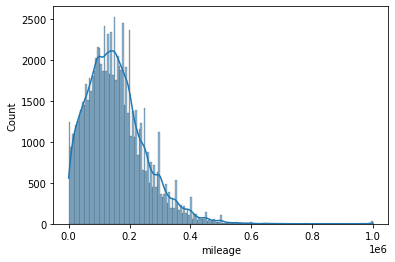

In [193]:
sns.histplot(data=df, x="mileage", kde=True)

In [91]:
df.plt.hist()

AttributeError: 'DataFrame' object has no attribute 'plt'

## 2.2.9 modelDate

In [194]:
df.modelDate.isna().sum()

0

In [195]:
df.modelDate.value_counts()

2012    5767
2010    5715
2011    5569
2015    5338
2013    5275
        ... 
1965       1
1963       1
1960       1
1934       1
1969       1
Name: modelDate, Length: 67, dtype: int64

<AxesSubplot:xlabel='modelDate', ylabel='Count'>

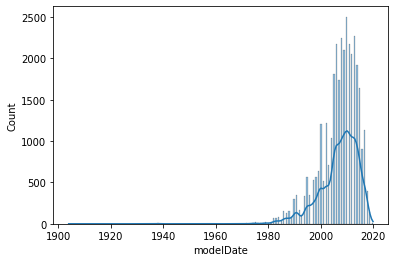

In [612]:
sns.histplot(data=df, x="modelDate", kde=True)

In [196]:
df = df.query('modelDate > 1980')

<AxesSubplot:xlabel='modelDate', ylabel='Count'>

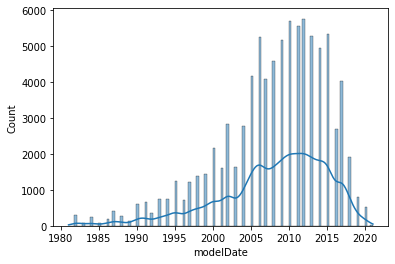

In [197]:
sns.histplot(data=df, x="modelDate", kde=True)


## 2.2.10 model_name

In [198]:
df.model_name.isna().sum()

0

In [199]:
df.model_name.value_counts()


Focus               1728
OCTAVIA             1418
A6                  1332
X5                  1213
Octavia             1158
                    ... 
Element                1
POLO_GTI               1
SQ8                    1
405                    1
e-tron Sportback       1
Name: model_name, Length: 1244, dtype: int64

## 2.2.11 name
_No information can be used_
_has to be droped_

In [205]:
df.name.isna().sum()

0

In [206]:
df.name.value_counts()


1.6 AT (110 л.с.)             1354
2.0 AT (150 л.с.)             1283
1.6 MT (105 л.с.)              936
1.6 AT (123 л.с.)              893
1.6 MT (102 л.с.)              809
                              ... 
Long 5.0 AT (525 л.с.) 4WD       1
Noah 2.0 MT (130 л.с.) 4WD       1
2.0d MT (130 л.с.)               1
2.2 AT (141 л.с.)                1
300 3.0d MT (136 л.с.)           1
Name: name, Length: 4106, dtype: int64

In [207]:
df.drop(['name'], axis=1, inplace=True)

## 2.2.11 numberOfDoors

In [210]:
df.numberOfDoors.isna().sum()

0

In [211]:
df.numberOfDoors.value_counts()

5    49393
4    33598
3     2407
2     2406
Name: numberOfDoors, dtype: int64

## 2.2.12 productionDate

In [213]:
df.productionDate.isna().sum()

0

In [214]:
df.productionDate.value_counts()


2012    6864
2008    6324
2013    6301
2011    5985
2014    5549
2018    5102
2017    4917
2007    4712
2016    4566
2015    4540
2010    4378
2019    3777
2006    3191
2005    2414
2009    2297
2004    2104
2020    1837
2003    1766
2002    1495
2001    1438
1998    1194
2000    1135
1999    1132
1997     965
2021     571
1996     558
1992     474
1993     437
1995     432
1994     408
1991     385
1990     243
1989      89
1988      83
1987      56
1986      35
1985      28
1984      13
1982       5
1983       4
Name: productionDate, dtype: int64

<AxesSubplot:xlabel='productionDate', ylabel='Count'>

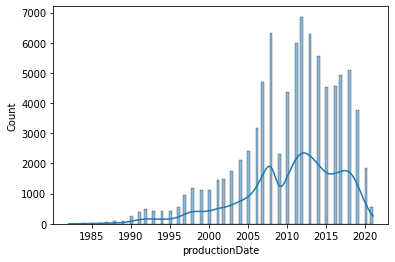

In [215]:
sns.histplot(data=df, x="productionDate", kde=True)


## 2.2.13 vehicleTransmission

In [217]:
df.vehicleTransmission.isna().sum()

0

In [216]:
df.vehicleTransmission.value_counts()

автоматическая      47895
механическая        23673
вариатор             8772
роботизированная     7464
Name: vehicleTransmission, dtype: int64

## 2.2.13 vendor

In [218]:
df.vendor.isna().sum()

0

In [219]:
df.vendor.value_counts()

EUROPEAN    43983
JAPANESE    27410
KOREAN       7352
AMERICAN     5127
RUSSIAN      3932
Name: vendor, dtype: int64

<AxesSubplot:xlabel='count', ylabel='vendor'>

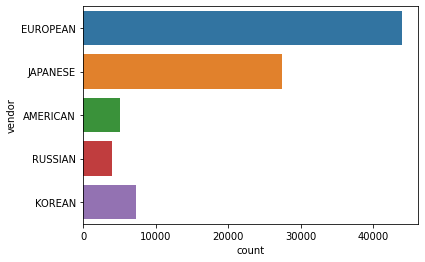

In [220]:
sns.countplot(y = df.vendor)

## 2.2.13 Владельцы

In [221]:
df.Владельцы.isna().sum()

0

In [222]:
df.Владельцы.value_counts()

1              16444
3 или более    15898
2              13854
3              12588
4              10362
1 владелец      9432
2 владельца     9226
Name: Владельцы, dtype: int64

In [233]:
df['Владельцы'] = float_value(df['Владельцы']).astype(int)
df['Владельцы'].value_counts(sort=True)

3    28486
1    25876
2    23080
4    10362
Name: Владельцы, dtype: int64

<AxesSubplot:xlabel='count', ylabel='Владельцы'>

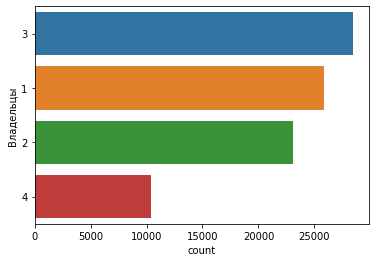

In [237]:
sns.countplot(y = df.Владельцы, order = df.Владельцы.value_counts().index)

## 2.2.13 Владение
_the biggest part of the values looks not valid_
_it has to be droped_

In [242]:
df.Владение.isna().sum()

23185

In [241]:
df.Владение.value_counts()

12.0                   52674
1 год и 10 месяцев       209
2 года                   197
1 год                    193
1 год и 1 месяц          192
                       ...  
26 лет и 7 месяцев         1
18 лет и 9 месяцев         1
18 лет и 10 месяцев        1
20 лет и 8 месяцев         1
27 лет и 9 месяцев         1
Name: Владение, Length: 271, dtype: int64

In [243]:
df.drop(['Владение'], axis=1, inplace=True)

## 2.2.14 ПТС

In [246]:
df.ПТС.isna().sum()
df.ПТС.fillna(df.ПТС.value_counts().keys()[0], inplace=True)

In [249]:
df.ПТС.value_counts()

Оригинал    75963
Дубликат    11841
Name: ПТС, dtype: int64

## 2.2.15 Привод

In [250]:
df.Привод.isna().sum()

0

In [251]:
df.Привод.value_counts()

передний    45535
полный      34620
задний       7649
Name: Привод, dtype: int64

<AxesSubplot:xlabel='count', ylabel='Привод'>

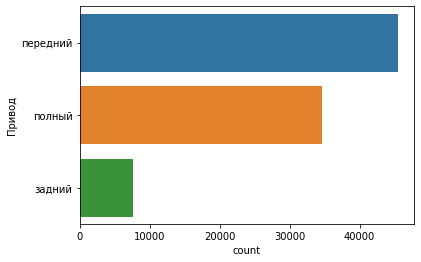

In [252]:
sns.countplot(y = df.Привод, order = df.Привод.value_counts().index)

## 2.2.16 Руль

In [253]:
df.Руль.isna().sum()

0

In [254]:
df.Руль.value_counts()

Левый     85191
Правый     2613
Name: Руль, dtype: int64

In [ ]:
  , 'sample', 'abs', 'airbag-driver', 'airbag-passenger',
       'airbag-side', 'aux', 'computer', 'electro-mirrors',
       'electro-window-back', 'electro-window-front', 'esp',
       'front-seats-heat', 'immo', 'lock', 'mirrors-heat', 'multi-wheel',
       'ptf', 'usb', 'wheel-leather', 'wheel-power'],
      dtype='object')